In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style('whitegrid')
import re
import json
import string
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from kneed import KneeLocator
from collections import Counter
from itertools import chain
import warnings
from IPython.display import clear_output
warnings.filterwarnings("ignore")
import nltk
nltk.download('stopwords')
import ast

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
dataset = 'SoftwareData.csv'
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
punctuation = string.punctuation + '—'
min_rating = 2000000
nlp = spacy.load("en_core_web_sm")
vectorizer = TfidfVectorizer()
kmeans_params = {
    'init': 'random',
    'n_init': 10,
    'max_iter': 300,
    'random_state': 42
}
sse = []
n_k = range(1, 41)

In [4]:
df = pd.read_csv(dataset)

df.head()

,Column3,title,series,author,rating,description,language,genres,main Genre,Genre ID,...,publishDate,awards,numRatings,ratingsByStars,coverImg,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
0,100001,Memoirs of a Geisha,NaN,Arthur Golden,4.12,"A literary sensation and runaway bestseller, t...",English,"Fiction, Historical Fiction, Romance, Historic...",Fiction,1,...,2005,[],1717312,"['712950', '615702', '295184', '66518', '26958']",https://i.gr-assets.com/images/S/compressed.ph...,NaN,NaN,NaN,NaN,NaN
1,100002,The Alchemist,NaN,"Paulo Coelho (Goodreads Author), Alan R. Clark...",3.88,Paulo Coelho's enchanting novel has inspired a...,English,"Fiction, Classics, Fantasy, Philosophy, Novels",Fiction,1,...,2014,['NBDB National Book Award Nominee for Transla...,2107732,"['805221', '613564', '414410', '172160', '1023...",https://i.gr-assets.com/images/S/compressed.ph...,NaN,NaN,NaN,NaN,NaN
2,100003,The Help,NaN,Kathryn Stockett (Goodreads Author),4.47,Librarian's note: An alternate cover edition c...,English,"Fiction, Historical Fiction, Historical, Adult...",Fiction,1,...,2009,['Orange Prize Nominee for Fiction Longlist (2...,2164011,"['1300564', '636115', '176679', '34643', '16010']",https://i.gr-assets.com/images/S/compressed.ph...,NaN,NaN,NaN,NaN,NaN
3,100004,The Lovely Bones,NaN,Alice Sebold,3.82,"""My name was Salmon, like the fish; first name...",English,"Fiction, Mystery, Young Adult, Contemporary, F...",Fiction,1,...,2006,['Bram Stoker Award for Best First Novel (2002...,2014401,"['614520', '706917', '472058', '149445', '71461']",https://i.gr-assets.com/images/S/compressed.ph...,NaN,NaN,NaN,NaN,NaN
4,100005,Water for Elephants,NaN,Sara Gruen (Goodreads Author),4.09,Winner of the 2007 BookBrowse Award for Most P...,English,"Fiction, Historical Fiction, Romance, Historic...",Fiction,1,...,2007,['Book Sense Book of the Year Award for Adult ...,1379584,"['545209', '512513', '242028', '59367', '20467']",https://i.gr-assets.com/images/S/compressed.ph...,NaN,NaN,NaN,NaN,NaN


In [5]:
def strip_html(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def remove_stopwords(text):
    text = text.split()
    text = [word for word in text if word not in stopwords]
    return ' '.join(text)

def remove_digits(text):
    text = re.sub(r'[0-9]', '', text)
    return text

def remove_punctuation(text):
    text = ''.join([word for word in text if word not in punctuation])
    return text

def get_keywords(text):
    doc = nlp(text)
    return ' '.join([item.text.strip() for item in doc.ents])

def parse_text(text):
    text = text.lower()
    text = strip_html(text)
    text = remove_stopwords(text)
    text = remove_digits(text)
    text = remove_punctuation(text)
    text = get_keywords(text)
    return text

In [6]:
df.drop(['series', 'language', 'Genre ID', 'GenreCount' , 'Column1', 'Column2', 'bookFormat', 
         'edition', 'pages', 'publisher', 'publishDate', 'awards', 'ratingsByStars', 'coverImg'], axis = 1, inplace = True)

df.head()

,Column3,title,author,rating,description,genres,main Genre,numRatings,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
0,100001,Memoirs of a Geisha,Arthur Golden,4.12,"A literary sensation and runaway bestseller, t...","Fiction, Historical Fiction, Romance, Historic...",Fiction,1717312,NaN,NaN,NaN,NaN,NaN
1,100002,The Alchemist,"Paulo Coelho (Goodreads Author), Alan R. Clark...",3.88,Paulo Coelho's enchanting novel has inspired a...,"Fiction, Classics, Fantasy, Philosophy, Novels",Fiction,2107732,NaN,NaN,NaN,NaN,NaN
2,100003,The Help,Kathryn Stockett (Goodreads Author),4.47,Librarian's note: An alternate cover edition c...,"Fiction, Historical Fiction, Historical, Adult...",Fiction,2164011,NaN,NaN,NaN,NaN,NaN
3,100004,The Lovely Bones,Alice Sebold,3.82,"""My name was Salmon, like the fish; first name...","Fiction, Mystery, Young Adult, Contemporary, F...",Fiction,2014401,NaN,NaN,NaN,NaN,NaN
4,100005,Water for Elephants,Sara Gruen (Goodreads Author),4.09,Winner of the 2007 BookBrowse Award for Most P...,"Fiction, Historical Fiction, Romance, Historic...",Fiction,1379584,NaN,NaN,NaN,NaN,NaN


In [7]:
df.drop(['Unnamed: 22',	'Unnamed: 23',	'Unnamed: 24',	'Unnamed: 25'	,'Unnamed: 26'], axis = 1, inplace = True)
df.head()

,Column3,title,author,rating,description,genres,main Genre,numRatings
0,100001,Memoirs of a Geisha,Arthur Golden,4.12,"A literary sensation and runaway bestseller, t...","Fiction, Historical Fiction, Romance, Historic...",Fiction,1717312
1,100002,The Alchemist,"Paulo Coelho (Goodreads Author), Alan R. Clark...",3.88,Paulo Coelho's enchanting novel has inspired a...,"Fiction, Classics, Fantasy, Philosophy, Novels",Fiction,2107732
2,100003,The Help,Kathryn Stockett (Goodreads Author),4.47,Librarian's note: An alternate cover edition c...,"Fiction, Historical Fiction, Historical, Adult...",Fiction,2164011
3,100004,The Lovely Bones,Alice Sebold,3.82,"""My name was Salmon, like the fish; first name...","Fiction, Mystery, Young Adult, Contemporary, F...",Fiction,2014401
4,100005,Water for Elephants,Sara Gruen (Goodreads Author),4.09,Winner of the 2007 BookBrowse Award for Most P...,"Fiction, Historical Fiction, Romance, Historic...",Fiction,1379584


In [9]:
df['keywords'] = df['description'].apply(parse_text)

df.head()

,Column3,title,author,rating,description,genres,main Genre,numRatings,keywords
0,100001,Memoirs of a Geisha,Arthur Golden,4.12,"A literary sensation and runaway bestseller, t...","Fiction, Historical Fiction, Romance, Historic...",Fiction,1717312,literary sensation runaway bestseller one
1,100002,The Alchemist,"Paulo Coelho (Goodreads Author), Alan R. Clark...",3.88,Paulo Coelho's enchanting novel has inspired a...,"Fiction, Classics, Fantasy, Philosophy, Novels",Fiction,2107732,spain egyptian jim tierney
2,100003,The Help,Kathryn Stockett (Goodreads Author),4.47,Librarian's note: An alternate cover edition c...,"Fiction, Historical Fiction, Historical, Adult...",Fiction,2164011,one maid constantine one seventeenth mississip...
3,100004,The Lovely Bones,Alice Sebold,3.82,"""My name was Salmon, like the fish; first name...","Fiction, Mystery, Young Adult, Contemporary, F...",Fiction,2014401,first fourteen december griefstricken
4,100005,Water for Elephants,Sara Gruen (Goodreads Author),4.09,Winner of the 2007 BookBrowse Award for Most P...,"Fiction, Historical Fiction, Romance, Historic...",Fiction,1379584,popular bookan atmospheric jacob jankowski men...


In [11]:
df['genres'] = df['genres'].apply(lambda x: str(["{}".format(genre.strip()) for genre in x.split(',')]))
df['genres'] = df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['genres'] = df['genres'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
def add_hyphens(genre_string):
    return ", ".join([genre.replace(" ", "-") for genre in genre_string.split(", ")])
df['hyphenated_genres'] = df['genres'].apply(add_hyphens)
features = ['Column3','title', 'author', 'genres', 'keywords']
final_df = df.loc[:, features]
def transform_genres(genre_string):
    genres_transformed = [genre.strip().replace(" ", "-") for genre in genre_string.split(",")]
    return " ".join(genres_transformed)

final_df['genres'] = final_df['genres'].apply(transform_genres)
final_df['keywords'] = final_df['keywords'].astype(str).apply(lambda x: ' '.join(x.split()))

final_df['corpus'] =  final_df[['genres', 'keywords']].agg(' '.join, axis=1).str.lower()

In [12]:
final_df.head()

,Column3,title,author,genres,keywords,corpus
0,100001,Memoirs of a Geisha,Arthur Golden,Fiction Historical-Fiction Romance Historical ...,literary sensation runaway bestseller one,fiction historical-fiction romance historical ...
1,100002,The Alchemist,"Paulo Coelho (Goodreads Author), Alan R. Clark...",Fiction Classics Fantasy Philosophy Novels,spain egyptian jim tierney,fiction classics fantasy philosophy novels spa...
2,100003,The Help,Kathryn Stockett (Goodreads Author),Fiction Historical-Fiction Historical Adult Ad...,one maid constantine one seventeenth mississip...,fiction historical-fiction historical adult ad...
3,100004,The Lovely Bones,Alice Sebold,Fiction Mystery Young-Adult Contemporary Fantasy,first fourteen december griefstricken,fiction mystery young-adult contemporary fanta...
4,100005,Water for Elephants,Sara Gruen (Goodreads Author),Fiction Historical-Fiction Romance Historical ...,popular bookan atmospheric jacob jankowski men...,fiction historical-fiction romance historical ...


In [13]:
tfidf = vectorizer.fit_transform(final_df['corpus'])
tfidf

<22177x26089 sparse matrix of type '<class 'numpy.float64'>'
	with 246026 stored elements in Compressed Sparse Row format>

In [14]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000) 
X = vectorizer.fit_transform(final_df['corpus'])

svd = TruncatedSVD(n_components=300) 
X_reduced = svd.fit_transform(X)

cosine_sim = cosine_similarity(X_reduced)

In [15]:
cosine_sim

array([[ 1.        ,  0.15669945,  0.57740714, ...,  0.04564915,
         0.03482336,  0.00189111],
       [ 0.15669945,  1.        ,  0.06326624, ...,  0.01659954,
         0.01357653, -0.01009319],
       [ 0.57740714,  0.06326624,  1.        , ...,  0.05760534,
         0.06259951, -0.00110412],
       ...,
       [ 0.04564915,  0.01659954,  0.05760534, ...,  1.        ,
         0.64683501,  0.15554188],
       [ 0.03482336,  0.01357653,  0.06259951, ...,  0.64683501,
         1.        ,  0.23497241],
       [ 0.00189111, -0.01009319, -0.00110412, ...,  0.15554188,
         0.23497241,  1.        ]])

In [16]:
for k in n_k:
    kmeans = KMeans(n_clusters=k, **kmeans_params).fit(tfidf)
    sse.append(kmeans.inertia_)
print(len(n_k), len(sse))

40 40


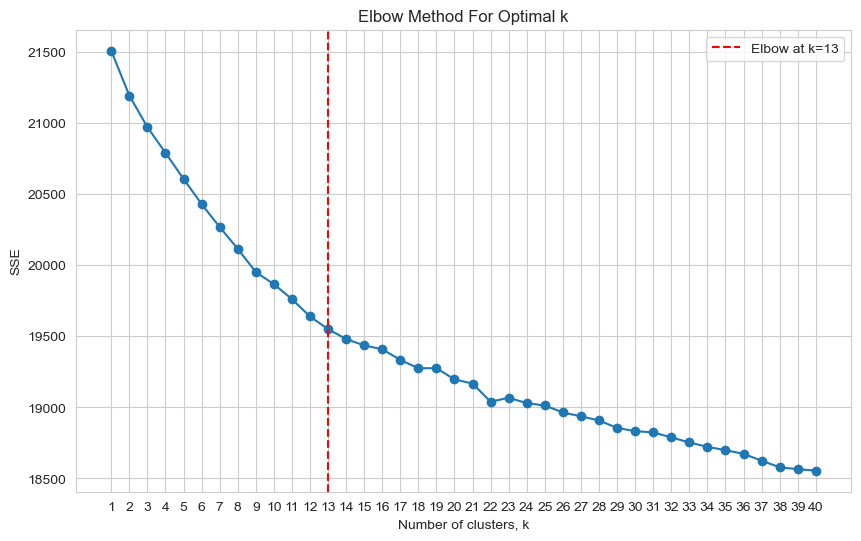

In [17]:
import matplotlib.pyplot as plt
from kneed import KneeLocator

n_k = range(1, len(sse)+1)  

plt.figure(figsize=(10, 6))
plt.plot(n_k, sse, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters, k')
plt.ylabel('SSE')
plt.xticks(list(n_k))  
locator = KneeLocator(list(n_k), sse, curve='convex', direction='decreasing')
plt.axvline(x=locator.elbow, linestyle='--', color='r', label=f'Elbow at k={locator.elbow}')
plt.legend()
plt.savefig('elbow_method_plot.png', format='png', dpi=300)
plt.show(block=False)

In [20]:
kmeans = KMeans(n_clusters=locator.elbow, **kmeans_params)
kmeans.fit(cosine_sim)
final_df['cluster'] = kmeans.labels_
final_df.head()

,Column3,title,author,genres,keywords,corpus,cluster
0,100001,Memoirs of a Geisha,Arthur Golden,Fiction Historical-Fiction Romance Historical ...,literary sensation runaway bestseller one,fiction historical-fiction romance historical ...,7
1,100002,The Alchemist,"Paulo Coelho (Goodreads Author), Alan R. Clark...",Fiction Classics Fantasy Philosophy Novels,spain egyptian jim tierney,fiction classics fantasy philosophy novels spa...,5
2,100003,The Help,Kathryn Stockett (Goodreads Author),Fiction Historical-Fiction Historical Adult Ad...,one maid constantine one seventeenth mississip...,fiction historical-fiction historical adult ad...,7
3,100004,The Lovely Bones,Alice Sebold,Fiction Mystery Young-Adult Contemporary Fantasy,first fourteen december griefstricken,fiction mystery young-adult contemporary fanta...,12
4,100005,Water for Elephants,Sara Gruen (Goodreads Author),Fiction Historical-Fiction Romance Historical ...,popular bookan atmospheric jacob jankowski men...,fiction historical-fiction romance historical ...,7


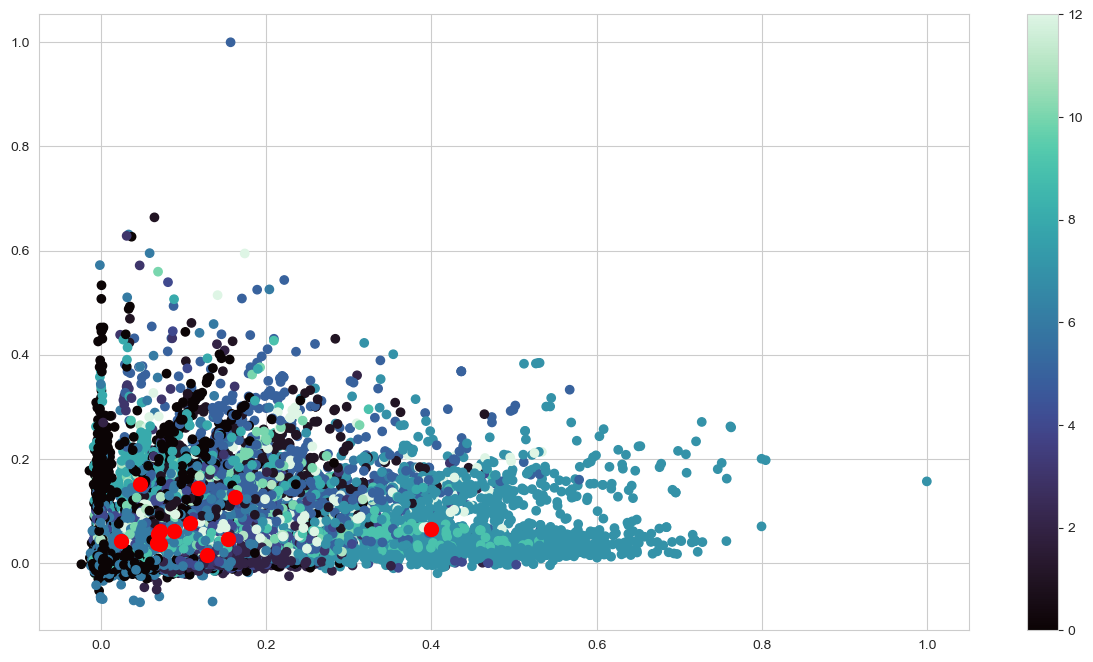

In [21]:
plt.figure(figsize=(15,8))
output = plt.scatter(cosine_sim[:,0], cosine_sim[:,1], c=final_df.cluster, marker='o', alpha=1, cmap='mako')
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='red', s=100, alpha=1 , marker='o')
plt.colorbar(output)
plt.savefig('cluster_scatter_plot.png', format='png', dpi=300)
plt.show(block=False)

In [24]:
book_map = {title: idx for idx, title in enumerate(final_df['title'])}
def get_recommendation(title, top_n=11):
    book_id = book_map[title]

    sim_score = list(enumerate(cosine_sim[book_id]))
    sim_score = sorted(sim_score, key=lambda x: x[1], reverse=True)
    sim_score = sim_score[:top_n]

    book_indices = [score[0] for score in sim_score]
    scores = [score[1] for score in sim_score]
    top_n_recommendation = final_df[['Column3','title', 'author', 'genres']].iloc[book_indices]
    top_n_recommendation['genres'] = top_n_recommendation['genres'].apply(lambda x: x.split())
    top_n_recommendation['score'] = scores
    return top_n_recommendation.iloc[1:]


In [93]:
test_book = final_df.sample(1, random_state=763)
test_book

,Column3,title,author,genres,keywords,corpus,cluster
6999,107000,Final Exam,A. Bates,Young-Adult Horror Thriller Fiction Mystery,kelly,young-adult horror thriller fiction mystery kelly,3


In [94]:
test_title = test_book['title'].values[0]
pd.set_option('display.max_colwidth', None)
test_df = final_df[['title', 'author', 'genres', 'cluster']].loc[final_df['title'] == test_title]
test_df['genres'] = test_df['genres'].apply(lambda x: x.split())
test_df

,title,author,genres,cluster
6999,Final Exam,A. Bates,"[Young-Adult, Horror, Thriller, Fiction, Mystery]",3


In [95]:
book_map = pd.Series(final_df.index, index=final_df['title'])
book_map.head()

title
Memoirs of a Geisha    0
The Alchemist          1
The Help               2
The Lovely Bones       3
Water for Elephants    4
dtype: int64

In [96]:
recommendation = get_recommendation(test_title)
recommendation

,Column3,title,author,genres,score
6929,106930,Scavenger Hunt,Christopher Pike,"[Young-Adult, Horror, Fiction, Thriller, Mystery]",0.901104
14263,114264,DSM,"M.J. Winn (Goodreads Author), Michael Winn","[Horror, Mystery, Thriller]",0.842531
7144,107145,Killing Mr. Griffin,Lois Duncan,"[Young-Adult, Mystery, Fiction, Horror, Thriller]",0.834285
14153,114154,Pin,Andrew Neiderman,"[Horror, Fiction, Thriller, Mystery, Mystery-Thriller]",0.824093
14206,114207,The Mouse on the Mile,Stephen King (Goodreads Author),"[Horror, Fiction, Thriller, Fantasy, Mystery]",0.813948
13917,113918,Penpal,Dathan Auerbach (Goodreads Author),"[Horror, Fiction, Mystery, Thriller, Adult]",0.808912
6528,106529,Still Waters,Emma Carlson Berne (Goodreads Author),"[Young-Adult, Mystery, Horror, Thriller, Romance]",0.793974
5955,105956,Stranger with My Face,Lois Duncan,"[Young-Adult, Horror, Fiction, Mystery, Thriller]",0.773528
16530,116531,The Select,F. Paul Wilson (Goodreads Author),"[Thriller, Horror, Fiction, Mystery, Medical]",0.773187
14088,114089,Creature,John Saul,"[Horror, Fiction, Thriller, Science-Fiction, Mystery]",0.771572


In [97]:
recommendation['cluster'] = recommendation['title'].apply(
    lambda x: final_df.loc[final_df['title'] == x, 'cluster'].values[0] \
    if x in final_df['title'].values.tolist() else False)
recommendation

,Column3,title,author,genres,score,cluster
6929,106930,Scavenger Hunt,Christopher Pike,"[Young-Adult, Horror, Fiction, Thriller, Mystery]",0.901104,3
14263,114264,DSM,"M.J. Winn (Goodreads Author), Michael Winn","[Horror, Mystery, Thriller]",0.842531,3
7144,107145,Killing Mr. Griffin,Lois Duncan,"[Young-Adult, Mystery, Fiction, Horror, Thriller]",0.834285,3
14153,114154,Pin,Andrew Neiderman,"[Horror, Fiction, Thriller, Mystery, Mystery-Thriller]",0.824093,3
14206,114207,The Mouse on the Mile,Stephen King (Goodreads Author),"[Horror, Fiction, Thriller, Fantasy, Mystery]",0.813948,3
13917,113918,Penpal,Dathan Auerbach (Goodreads Author),"[Horror, Fiction, Mystery, Thriller, Adult]",0.808912,3
6528,106529,Still Waters,Emma Carlson Berne (Goodreads Author),"[Young-Adult, Mystery, Horror, Thriller, Romance]",0.793974,3
5955,105956,Stranger with My Face,Lois Duncan,"[Young-Adult, Horror, Fiction, Mystery, Thriller]",0.773528,3
16530,116531,The Select,F. Paul Wilson (Goodreads Author),"[Thriller, Horror, Fiction, Mystery, Medical]",0.773187,3
14088,114089,Creature,John Saul,"[Horror, Fiction, Thriller, Science-Fiction, Mystery]",0.771572,3


In [98]:
eval_title = 'Scavenger Hunt'
high_score = get_recommendation(eval_title)
high_score

,Column3,title,author,genres,score
6999,107000,Final Exam,A. Bates,"[Young-Adult, Horror, Thriller, Fiction, Mystery]",0.901104
13917,113918,Penpal,Dathan Auerbach (Goodreads Author),"[Horror, Fiction, Mystery, Thriller, Adult]",0.873756
14216,114217,The Bad Death of Eduard Delacroix,Stephen King (Goodreads Author),"[Horror, Fiction, Thriller, Fantasy, Mystery]",0.790757
14263,114264,DSM,"M.J. Winn (Goodreads Author), Michael Winn","[Horror, Mystery, Thriller]",0.780219
7144,107145,Killing Mr. Griffin,Lois Duncan,"[Young-Adult, Mystery, Fiction, Horror, Thriller]",0.773690
3767,103768,Cuckoo Song,Frances Hardinge,"[Fantasy, Horror, Young-Adult, Historical-Fiction, Mystery]",0.771563
14153,114154,Pin,Andrew Neiderman,"[Horror, Fiction, Thriller, Mystery, Mystery-Thriller]",0.762959
14206,114207,The Mouse on the Mile,Stephen King (Goodreads Author),"[Horror, Fiction, Thriller, Fantasy, Mystery]",0.754933
13833,113834,Intensity,Dean Koontz (Goodreads Author),"[Horror, Fiction, Thriller, Suspense, Mystery]",0.754818
7198,107199,Nerve,Jeanne Ryan (Goodreads Author),"[Young-Adult, Thriller, Science-Fiction, Fiction, Mystery]",0.751229


In [99]:
score = recommendation['score']
score

6929     0.901104
14263    0.842531
7144     0.834285
14153    0.824093
14206    0.813948
13917    0.808912
6528     0.793974
5955     0.773528
16530    0.773187
14088    0.771572
Name: score, dtype: float64

In [100]:
test_cluster = test_df['cluster'].values[0]
print('The cluster for test data is:', test_cluster)

The cluster for test data is: 3


In [101]:
def get_relevant_items(cluster, score, threshold=0.5):
    relevant_item = recommendation.loc[(recommendation['cluster'] == cluster) & (score > threshold)]
    return relevant_item

def get_recommended_items(k):
    recommended_item = recommendation.iloc[:k]
    return recommended_item

def get_recommended_and_relevant(cluster, score):
    relevant_item = get_relevant_items(cluster, score)
    recommended_item = get_recommended_items(len(relevant_item))
    recommended_relevant = pd.merge(relevant_item, recommended_item, how='inner', on='title')
    
    total_relevant_item = len(relevant_item)
    total_recommended_item = len(recommended_item)
    total_recommended_relevant = len(recommended_relevant)
    
    return total_relevant_item, total_recommended_item, total_recommended_relevant

def precision_at_k(total_recommended_relevant, total_recommended_item):
    if total_recommended_item == 0:
        return 'Cannot compute precision@k zero division'
    precision = total_recommended_relevant / total_recommended_item
    return precision

def recall_at_k(total_recommended_relevant, total_relevant_item):
    if total_relevant_item == 0:
        return 'Cannot compute recall@k zero division'
    recall = total_recommended_relevant / total_relevant_item
    return recall

In [102]:
total_relevant_item, total_recommended_item, total_recommended_relevant = get_recommended_and_relevant(test_cluster, score)
print('Total relevant item:', total_relevant_item)
print(f'Total recommended item at {total_relevant_item}:', total_recommended_item)
print('Total recommended item that relevant:', total_recommended_relevant)

Total relevant item: 10
Total recommended item at 10: 10
Total recommended item that relevant: 10


In [103]:
precision = precision_at_k(total_recommended_relevant, total_recommended_item)
recall = recall_at_k(total_recommended_relevant, total_relevant_item)
print('The precision@%d for this recommender system is: %.2f' % (total_recommended_item, precision * 100), '%')
print('The recall@%d for this recommender system is: %.2f' % (total_recommended_item, recall * 100), '%')

The precision@10 for this recommender system is: 100.00 %
The recall@10 for this recommender system is: 100.00 %


In [104]:
book_test = final_df.loc[final_df['cluster'] == test_cluster]
recommendation.loc[recommendation['title'].isin(book_test['title'])]

,Column3,title,author,genres,score,cluster
6929,106930,Scavenger Hunt,Christopher Pike,"[Young-Adult, Horror, Fiction, Thriller, Mystery]",0.901104,3
14263,114264,DSM,"M.J. Winn (Goodreads Author), Michael Winn","[Horror, Mystery, Thriller]",0.842531,3
7144,107145,Killing Mr. Griffin,Lois Duncan,"[Young-Adult, Mystery, Fiction, Horror, Thriller]",0.834285,3
14153,114154,Pin,Andrew Neiderman,"[Horror, Fiction, Thriller, Mystery, Mystery-Thriller]",0.824093,3
14206,114207,The Mouse on the Mile,Stephen King (Goodreads Author),"[Horror, Fiction, Thriller, Fantasy, Mystery]",0.813948,3
13917,113918,Penpal,Dathan Auerbach (Goodreads Author),"[Horror, Fiction, Mystery, Thriller, Adult]",0.808912,3
6528,106529,Still Waters,Emma Carlson Berne (Goodreads Author),"[Young-Adult, Mystery, Horror, Thriller, Romance]",0.793974,3
5955,105956,Stranger with My Face,Lois Duncan,"[Young-Adult, Horror, Fiction, Mystery, Thriller]",0.773528,3
16530,116531,The Select,F. Paul Wilson (Goodreads Author),"[Thriller, Horror, Fiction, Mystery, Medical]",0.773187,3
14088,114089,Creature,John Saul,"[Horror, Fiction, Thriller, Science-Fiction, Mystery]",0.771572,3
